### 22.Problem Statement

I decided to treat this as a classification problem by creating a new binary variable affair
(did the woman have at least one affair?) and trying to predict the classification for each
woman.

**Dataset**
The dataset I chose is the affairs dataset that comes with Statsmodels. It was derived
from a survey of women in 1974 by Redbook magazine, in which married women were
asked about their participation in extramarital affairs. More information about the study
is available in a 1978 paper from the Journal of Political Economy.

**Description of Variables**
The dataset contains 6366 observations of 9 variables:

rate_marriage: woman's rating of her marriage (1 = very poor, 5 = very good)
age: woman's age
yrs_married: number of years married
children: number of children
religious: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)
educ: level of education (9 = grade school, 12 = high school, 14 = some college, 16 =
college graduate, 17 = some graduate school, 20 = advanced degree)

occupation: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 =
"white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 =
professional with advanced degree)
occupation_husb: husband's occupation (same coding as above)

affairs: time spent in extra-marital affairs


In [31]:
# Code to loading data and modules

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

dta = sm.datasets.fair.load_pandas().data

# add "affair" column: 1 represents having affairs, 0 represents not
dta['affair'] = (dta.affairs > 0).astype(int)

y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
religious + educ + C(occupation) + C(occupation_husb)',
dta, return_type="dataframe")


In [32]:
X.columns

Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')

In [33]:
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
'C(occupation)[T.3.0]':'occ_3',
'C(occupation)[T.4.0]':'occ_4',
'C(occupation)[T.5.0]':'occ_5',
'C(occupation)[T.6.0]':'occ_6',
'C(occupation_husb)[T.2.0]':'occ_husb_2',
'C(occupation_husb)[T.3.0]':'occ_husb_3',
'C(occupation_husb)[T.4.0]':'occ_husb_4',
'C(occupation_husb)[T.5.0]':'occ_husb_5',
'C(occupation_husb)[T.6.0]':'occ_husb_6'})
y = np.ravel(y)

In [34]:
dta.tail()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
6361,5.0,32.0,13.0,2.0,3.0,17.0,4.0,3.0,0.0,0
6362,4.0,32.0,13.0,1.0,1.0,16.0,5.0,5.0,0.0,0
6363,5.0,22.0,2.5,0.0,2.0,14.0,3.0,1.0,0.0,0
6364,5.0,32.0,6.0,1.0,3.0,14.0,3.0,4.0,0.0,0
6365,4.0,22.0,2.5,0.0,2.0,16.0,2.0,4.0,0.0,0


In [8]:
dta.shape

(6366, 10)

In [10]:
dta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 10 columns):
rate_marriage      6366 non-null float64
age                6366 non-null float64
yrs_married        6366 non-null float64
children           6366 non-null float64
religious          6366 non-null float64
educ               6366 non-null float64
occupation         6366 non-null float64
occupation_husb    6366 non-null float64
affairs            6366 non-null float64
affair             6366 non-null int32
dtypes: float64(9), int32(1)
memory usage: 472.5 KB


In [9]:
dta.describe()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.705374,0.322495
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,2.203374,0.467468
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.484848,1.000000
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,57.599991,1.000000


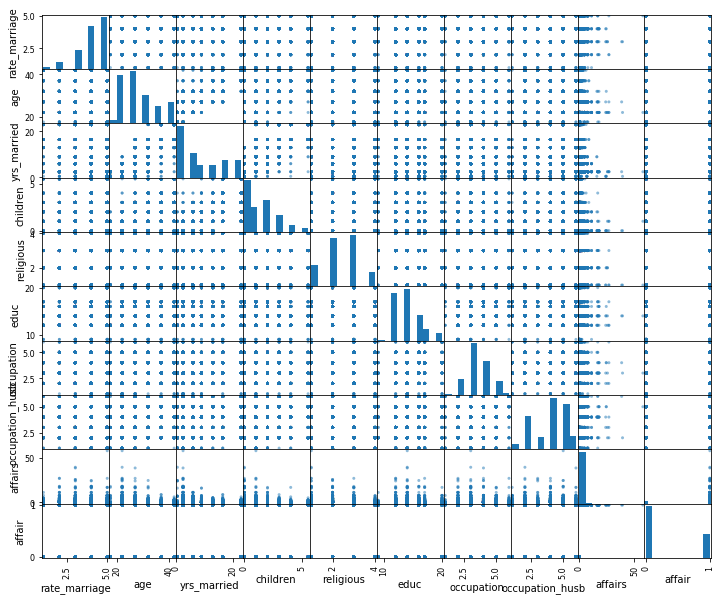

In [14]:
plt.rcParams['figure.figsize']=12,10
from pandas.plotting import scatter_matrix
scatter_matrix(dta)
plt.show()

In [21]:
impt = dta.pivot_table(values=['affairs'],index=['rate_marriage','religious'],aggfunc=np.mean)
print(impt)

                          affairs
rate_marriage religious          
1.0           1.0        1.334104
              2.0        1.448427
              3.0        0.992806
              4.0        0.725943
2.0           1.0        3.299485
              2.0        1.603516
              3.0        1.087526
              4.0        0.472174
3.0           1.0        2.382038
              2.0        1.305844
              3.0        1.066625
              4.0        0.673102
4.0           1.0        1.005887
              2.0        0.770306
              3.0        0.531323
              4.0        0.303108
5.0           1.0        0.691137
              2.0        0.337247
              3.0        0.305064
              4.0        0.102562


#### Check for missing values

In [15]:
dta.isnull().sum()

rate_marriage      0
age                0
yrs_married        0
children           0
religious          0
educ               0
occupation         0
occupation_husb    0
affairs            0
affair             0
dtype: int64

### Model building

#### Model 1: Using statsmodel

In [66]:
import warnings
warnings.filterwarnings('ignore')

X['intercept']= 1.0
feat_names = X.columns[:10]
model1 = sm.Logit(y,X)
results = model1.fit()

results.summary()


         Current function value: 0.542911
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6366
Model:                          Logit   Df Residuals:                     6349
Method:                           MLE   Df Model:                           16
Date:                Fri, 22 Jun 2018   Pseudo R-squ.:                  0.1365
Time:                        18:53:32   Log-Likelihood:                -3456.2
converged:                      False   LL-Null:                       -4002.5
                                        LLR p-value:                1.534e-222
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4854   2.38e+06   6.24e-07      1.000   -4.66e+06    4.66e+06
occ_2             0.3902      0.448      0.872      0.383      -0.487       1.267
occ_3             0.7027      0.441      1.592      0.111      -0.163       1.568
occ_4             0.4714      0.443      1.065      0.287      -0.396       1.339
occ_5             1.0542      0.447      2.360      0.018       0.179       1.930
occ_6             1.1080      0.494      2.242      0.025       0.139       2.077
occ_husb_2        0.1704      0.186      0.916      0.360      -0.194       0.535
occ_husb_3        0.2842      0.202      1.406      0.160      -0.112       0.680
occ_husb_4        0.1428      0.181      0.789      0.430      -0.212       0.498
occ_husb_5        0.1723      0.183      0.944      0.345      -0.186       0.530
occ_husb_6        0.1828      0.204      0.897      0.369      -0.216       0.582
rate_marriage    -0.7102      0.031    -22.560      0.000      -0.772      -0.649
age              -0.0613      0.010     -5.936      0.000      -0.082      -0.041
yrs_married       0.1080      0.011      9.836      0.000       0.086       0.129
children          0.0156      0.032      0.488      0.625      -0.047       0.078
religious        -0.3754      0.035    -10.766      0.000      -0.444      -0.307
educ             -0.0017      0.017     -0.099      0.921      -0.036       0.032
intercept         1.4854   2.38e+06   6.24e-07      1.000   -4.66e+06    4.66e+06
=================================================================================
"""

#### Model2 : Using scikit learn

In [35]:
# Default model
# X = dta[feat_names]
# y = dta['affair']

model2 = LogisticRegression()
model2.fit(X,y)

pred = model2.score(X,y)

print(pred)

0.72588752749


#### Model3 : Using train_test_split

In [36]:
from sklearn import metrics

seed=5
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=seed)
model3 = LogisticRegression()
model3.fit(x_train,y_train)

pred = model3.predict(x_test)

score = metrics.accuracy_score(y_test,pred)
print(score)

0.724607329843


##### Find AUC value

In [37]:
probs = model3.predict_proba(x_test)

print(metrics.roc_auc_score(y_test, probs[:,1]))

0.752206139861


In [50]:
print(metrics.confusion_matrix(y_test,pred))
print(metrics.classification_report(y_test,pred))

[[1158  161]
 [ 365  226]]
             precision    recall  f1-score   support

        0.0       0.76      0.88      0.81      1319
        1.0       0.58      0.38      0.46       591

avg / total       0.71      0.72      0.71      1910



#### Model4: Using Crossvalidation

In [46]:
# cross_val_score from coss_validation
from sklearn.model_selection import KFold

model4 = LogisticRegression()

scores = cross_val_score(model4, X,y,scoring='accuracy',cv=5)
print(scores.mean())

0.724951373873


In [60]:
# cross_val_score from model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model4 = LogisticRegression()
kfold = KFold(n_splits=30, random_state=2) # we need to make 30 splits to get accuracy of 71%

scores = cross_val_score(model4, X,y,scoring='accuracy',cv=kfold)
print(scores.mean())

0.711347329259


In [57]:
#### Model5 : Using regularization terms
# cross_val_score from coss_validation
from sklearn.model_selection import KFold

model5 = LogisticRegression(penalty='l1',C=0.5)

scores = cross_val_score(model5, X,y,scoring='accuracy',cv=5)
print(scores.mean())

0.725894276433


In [62]:
# model5 - accuracy on unknown data
model5.fit(x_train,y_train)
pred_m5 = model5.predict(x_test)

# Accuracy on unknown data 
print(metrics.accuracy_score(y_test,pred_m5))

0.726701570681


In [64]:
probs = model5.predict_proba(x_test)
print(metrics.roc_auc_score(y_test,probs[:,1]))

0.751945726201


In [65]:
print(metrics.confusion_matrix(y_test,pred_m5))
print(metrics.classification_report(y_test,pred_m5))

[[1163  156]
 [ 366  225]]
             precision    recall  f1-score   support

        0.0       0.76      0.88      0.82      1319
        1.0       0.59      0.38      0.46       591

avg / total       0.71      0.73      0.71      1910



**The final model (model5) has given accuracy of 73% on test data with AUC value 0.75 ,with a high sensitivity/recall value
of 0.73**

**Logistic Regression is evaluated by:**
    1. AIC - Akaike information criterion
    2. Null deviance & Residual deviance
    3. Confusion Matrix
    4. AUC-ROC Curve

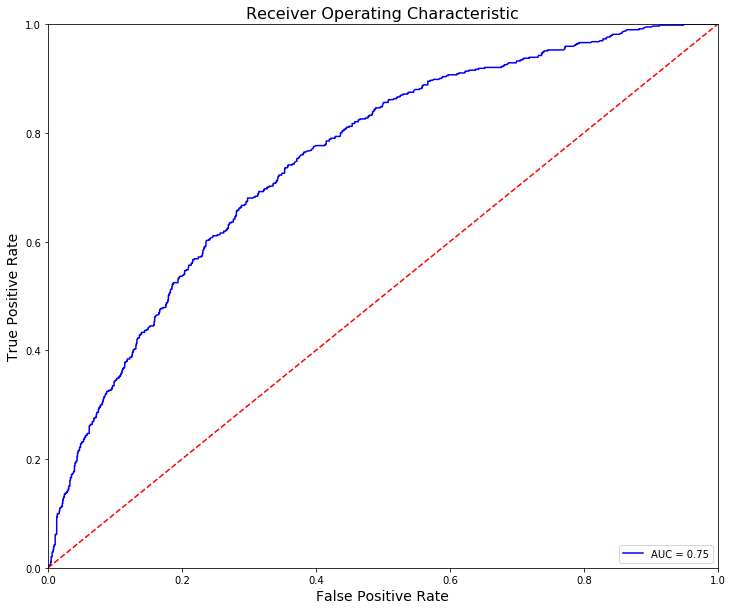

In [79]:
#### Plot AUC-ROC Curve

probs = model5.predict_proba(x_test)
preds = probs[:,1]
fpr,tpr,threshold = metrics.roc_curve(y_test,preds)
auc5 = metrics.auc(fpr,tpr)

plt.title('Receiver Operating Characteristic',size=16)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc5)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',size=14)
plt.xlabel('False Positive Rate',size=14)
plt.show()


In [74]:
# Gets 1st column of the matrix
probs[:,1]

array([ 0.20009925,  0.46557717,  0.4555136 , ...,  0.65176072,
        0.18357456,  0.16858155])